In [23]:
# basic python libraries
import numpy as np                  # for numerical operations
import scipy.special as sp         # for softmax function
import copy                        # for deep copies of state
import time                        # for timing animations
import random                      # for random sampling

# display and plotting
from IPython.display import display, clear_output  # for showing outputs in loop
import matplotlib.pyplot as plt                    # for plotting
import seaborn as sns                              # for heatmaps and advanced plots

# pytorch libraries
import torch                          # base library
import torch.nn as nn                 # neural network components
import torch.optim as optim           # optimization algorithms

# replay memory for dqn
import collections                   # for namedtuple and deque


**Introduce experience replay.**

In [24]:
# define a namedtuple for storing agent experience
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

# experience replay buffer for dqn
class ExperienceReplay:
    def __init__(self, capacity):
        # set max buffer size
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        # return current number of items in buffer
        return len(self.memory)

    def push(self, transition):
        # add a new transition to buffer
        self.memory.append(transition)

    def sample(self, batch_size, device='cuda'):
        # randomly select a batch of transitions
        indices = np.random.choice(len(self.memory), batch_size, replace=False)

        # unpack sampled transitions
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx]
                                                                for idx in indices])

        # convert to torch tensors and send to device
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), \
               torch.tensor(isgameon).to(device)


**Networks definition.**

In [25]:
# fully connected neural network for q-learning
class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No=4):
        super().__init__()

        # define network layers
        self.fc1 = nn.Linear(Ni, Nh1)    # input to hidden layer 1
        self.fc2 = nn.Linear(Nh1, Nh2)   # hidden layer 1 to hidden layer 2
        self.fc3 = nn.Linear(Nh2, No)    # hidden layer 2 to output

        # use relu activation
        self.act = nn.ReLU()

    def forward(self, x, classification=False, additional_out=False):
        # pass through hidden layers with activation
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))

        # output layer (raw q-values)
        out = self.fc3(x)
        return out


In [26]:
# convolutional neural network for q-learning
class conv_nn(nn.Module):

    # cnn architecture config
    channels = [16, 32, 64]     # number of channels per layer
    kernels = [3, 3, 3]         # kernel size for each layer
    strides = [1, 1, 1]         # stride for each layer
    in_channels = 1            # grayscale input

    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows      # maze height
        self.cols = cols      # maze width

        # define conv layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels,
                      out_channels=self.channels[0],
                      kernel_size=self.kernels[0],
                      stride=self.strides[0]),
            nn.ReLU(),

            nn.Conv2d(in_channels=self.channels[0],
                      out_channels=self.channels[1],
                      kernel_size=self.kernels[1],
                      stride=self.strides[1]),
            nn.ReLU()
        )

        # compute size after conv layers
        size_out_conv = self.get_conv_size(rows, cols)

        # define fully connected layers
        self.linear = nn.Sequential(
            nn.Linear(size_out_conv, rows * cols * 2),
            nn.ReLU(),
            nn.Linear(rows * cols * 2, int(rows * cols / 2)),
            nn.ReLU(),
            nn.Linear(int(rows * cols / 2), n_act)
        )

    def forward(self, x):
        # reshape to [batch, channels, height, width]
        x = x.view(len(x), self.in_channels, self.rows, self.cols)
        out_conv = self.conv(x).view(len(x), -1)   # apply conv layers
        out_lin = self.linear(out_conv)            # apply fc layers
        return out_lin

    def get_conv_size(self, x, y):
        # helper to calculate flattened output size after conv layers
        out_conv = self.conv(torch.zeros(1, self.in_channels, x, y))
        return int(np.prod(out_conv.size()))


In [27]:
# compute mean squared td loss for dqn update
def Qloss(batch, net, gamma=0.99, device="cuda"):
    # unpack batch
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)

    # get q-values for current states and actions taken
    state_action_values = net(states.view(lbatch, -1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)

    # get max q-value for next states
    next_state_values = net(next_states.view(lbatch, -1))
    next_state_values = next_state_values.max(1)[0]

    # detach to prevent gradient flow
    next_state_values = next_state_values.detach()

    # compute expected q-values
    expected_state_action_values = next_state_values * gamma + rewards

    # return mse loss
    return nn.MSELoss()(state_action_values, expected_state_action_values)


**Import the maze and define the environment.**

In [28]:
from environment import MazeEnvironment

# load maze from file
maze = np.load('maze_generator/maze.npy')

# set start and goal positions
initial_position = [0, 0]
goal = [len(maze) - 1, len(maze) - 1]

# create maze environment instance
maze_env = MazeEnvironment(maze, initial_position, goal)


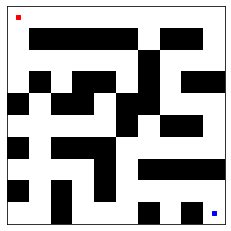

In [30]:
# draw and save the maze to a pdf file
maze_env.draw('maze_10.pdf')


**Define the agent and the buffer for experience replay.**

In [31]:
# define experience replay buffer
buffer_capacity = 10000           # max transitions to store
buffer_start_size = 1000          # min transitions before training starts
memory_buffer = ExperienceReplay(buffer_capacity)  # create replay buffer


In [32]:
from agent import Agent

# create agent instance with the maze environment and replay buffer
agent = Agent(maze=maze_env,
              memory_buffer=memory_buffer,
              use_softmax=True)  # use softmax sampling for action selection


** Define the network.**

In [33]:
# initialize fully connected Q-network
net = fc_nn(maze.size, maze.size, maze.size, 4)

# create Adam optimizer for training
optimizer = optim.Adam(net.parameters(), lr=1e-4)


In [34]:
# set training parameters
device = 'cuda'         # use gpu for faster computation
batch_size = 24         # number of samples per training step
gamma = 0.9             # discount factor for future rewards

# move network to gpu
net.to(device)


fc_nn(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
  (act): ReLU()
)

**Define the epsilon profile and plot the resetting probability.**

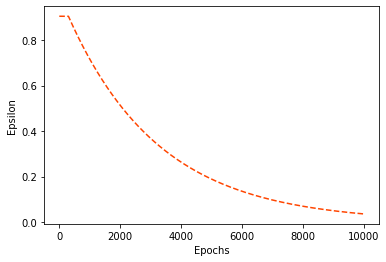

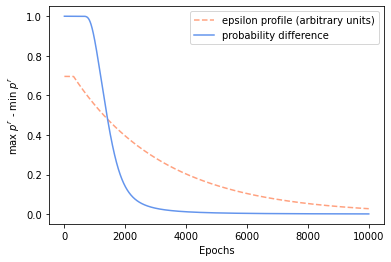

In [35]:
# total number of training episodes
num_epochs = 10000

# cutoff value for epsilon decay
cutoff = 3000

# exponential decay for exploration (epsilon-greedy / softmax temperature)
epsilon = np.exp(-np.arange(num_epochs) / cutoff)

# clip epsilon after a certain threshold to prevent it from becoming too small
epsilon[epsilon > epsilon[100 * int(num_epochs / cutoff)]] = epsilon[100 * int(num_epochs / cutoff)]

# plot epsilon decay over epochs
plt.plot(epsilon, color='orangered', ls='--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi=300, bbox_inches='tight')
plt.show()

# analyze how the reset policy (starting position distribution) changes with epsilon

mp = []    # minimum probability of reset positions
mpm = []   # maximum probability of reset positions
reg = 200  # regularization factor for policy sharpness

for e in epsilon:
    a = agent.env.reset_policy(e)  # get softmax reset distribution for current epsilon
    mp.append(np.min(a))           # store min reset prob
    mpm.append(np.max(a))          # store max reset prob

# plot how the reset probability range evolves with epsilon
plt.plot(epsilon / 1.3, color='orangered', ls='--', alpha=0.5,
         label='epsilon profile (arbitrary units)')

plt.plot(np.array(mpm) - np.array(mp), label='probability difference', color='cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig('reset_policy.pdf', dpi=300, bbox_inches='tight')
plt.show()


**Training the network.**

In [36]:
# initialize logs and tracking variables
loss_log = []
best_loss = 1e5
running_loss = 0

# start training over num_epochs
for epoch in range(num_epochs):
    loss = 0                # track loss per episode
    counter = 0             # number of steps/moves
    eps = epsilon[epoch]    # current epsilon value

    agent.isgameon = True   # reset game flag
    _ = agent.env.reset(eps)  # reset environment based on epsilon

    # run episode until agent reaches goal or fails
    while agent.isgameon:
        agent.make_a_move(net, eps)  # take a step based on policy
        counter += 1

        # skip training until buffer has enough samples
        if len(agent.buffer) < buffer_start_size:
            continue

        # sample batch and update q-network
        optimizer.zero_grad()
        batch = agent.buffer.sample(batch_size, device=device)
        loss_t = Qloss(batch, net, gamma=gamma, device=device)
        loss_t.backward()
        optimizer.step()

        loss += loss_t.item()

    # check if agent reached goal
    if (agent.env.current_position == agent.env.goal).all():
        result = 'won'
    else:
        result = 'lost'

    # every 1000 epochs, plot and save policy map
    if epoch % 1000 == 0:
        agent.plot_policy_map(net, 'sol_epoch_' + str(epoch) + '.pdf', [0.35, -0.3])

    # log episode loss
    loss_log.append(loss)

    # track best average loss over last 50 epochs
    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(net.state_dict(), "best.torch")  # save best model
            estop = epoch  # early stop epoch

    # print training progress
    print('epoch', epoch, '(number of moves:', counter, ')')
    print('game', result)
    print('[' + '#' * (100 - int(100 * (1 - epoch / num_epochs))) +
          ' ' * int(100 * (1 - epoch / num_epochs)) + ']')
    print('\t average loss:', f'{loss:.5f}')
    if epoch > 2000:
        print('\t best avg loss (last 50):', f'{best_loss:.5f}', ', at epoch', estop)

    clear_output(wait=True)


epoch 9999 (number of moves: 10 )
game won
[####################################################################################################]
	 average loss: 0.00321
	 best avg loss (last 50): 0.00009 , at epoch 6235


In [37]:
# save final model weights after training is complete
torch.save(net.state_dict(), "net.torch")


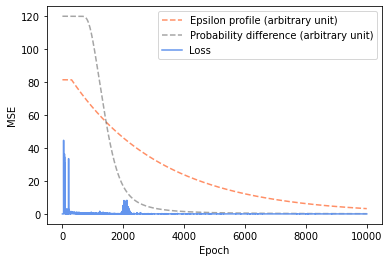

In [38]:
# plot 1: scaled epsilon profile (exploration rate trend)
plt.plot(epsilon * 90, alpha = 0.6, ls = '--',
         label = 'Epsilon profile (arbitrary unit)', color = 'orangered')

# plot 2: difference between max and min reset policy probabilities over time
plt.plot((np.array(mpm) - np.array(mp)) * 120, alpha = 0.6, ls = '--',
         label = 'Probability difference (arbitrary unit)', color = 'dimgray')

# plot 3: loss trend across all epochs
plt.plot(loss_log, label = 'Loss', color = 'cornflowerblue')

# set axis labels
plt.xlabel('Epoch')
plt.ylabel('MSE')

# display legend to differentiate curves
plt.legend()

# save the final plot to a PDF file
plt.savefig('loss.pdf', dpi = 300, bbox_inches='tight')

# display the plot
plt.show()


**Show the maze solution and the policy learnt.**

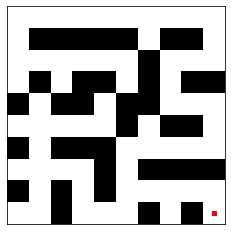

In [39]:
# set the network to evaluation mode (disables dropout, etc.)
net.eval()

# reset the agent’s game state
agent.isgameon = True

# switch to greedy policy (no softmax sampling — always take best action)
agent.use_softmax = False

# reset the environment with epsilon = 0 (favor goal during reset)
_ = agent.env.reset(0)

# run the episode until the goal is reached or game ends
while agent.isgameon:
    # agent makes a move using the trained policy (fully greedy)
    agent.make_a_move(net, 0)

    # visualize current maze with agent position (draws maze image)
    agent.env.draw('')  # (filename is blank so it will just show, not save)

    # clear the previous output to create an animation effect
    clear_output(wait = True)


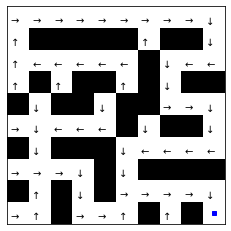

In [40]:
# Learning policy map
agent.plot_policy_map(net, 'solution.pdf', [0.35,-0.3])

**Heatmap**


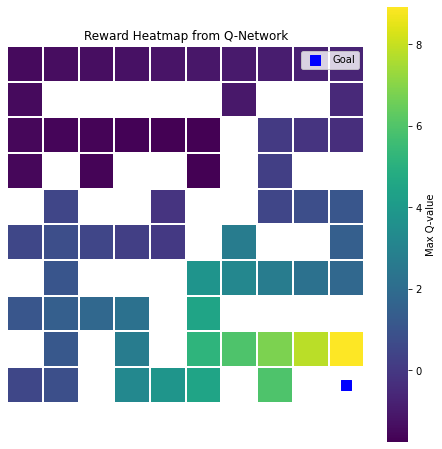

In [41]:
def plot_reward_heatmap(agent, net, filename='reward_heatmap.pdf'):
    net.eval()  # set network to evaluation mode
    maze_shape = agent.env.maze.shape
    heatmap = np.full(maze_shape, np.nan)  # initialize heatmap with NaNs (walls)

    with torch.no_grad():  # disable gradient tracking
        for cell in agent.env.allowed_states:
            agent.env.current_position = np.array(cell)  # set position
            state = torch.Tensor(agent.env.state()).view(1, -1).to('cuda')  # get input state
            q_values = net(state).cpu().numpy().squeeze()  # predict q-values
            max_q = np.max(q_values)  # take the max q-value
            heatmap[cell[0], cell[1]] = max_q  # store in heatmap

    # plot the heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap, cmap="viridis", linewidths=0.2,
                square=True, cbar_kws={'label': 'Max Q-value'},
                xticklabels=False, yticklabels=False)

    # mark the goal cell
    plt.scatter(agent.env.goal[1] + 0.5, agent.env.goal[0] + 0.5,
                s=100, c='blue', marker='s', label='Goal')

    plt.title("Reward Heatmap from Q-Network")
    plt.legend(loc='upper right')
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # save to file
    plt.show()  # display the plot

# generate and save the heatmap
plot_reward_heatmap(agent, net, filename='reward_heatmap.pdf')
